In [45]:
import pandas as pd
import numpy as np

# Read in our Data

In [46]:
season_stats = pd.read_csv("clean_data/season_stats.csv")
teams = pd.read_csv("clean_data/teams.csv")
ncaa_games = pd.read_csv("clean_data/ncaa_games.csv")
schools = pd.read_csv("clean_data/schools.csv")

# Build our Feature vector

In [47]:
# make a new dataframe:
data_matrix = ncaa_games.copy()

In [48]:
def build_feat_vec(r):
    """ 
    This function builds the feature vec by subtracting team_1's stats from team_2's stats
    """
    s1 = season_stats[season_stats["team_id"] == r["team_1_id"] ]
    s2 = season_stats[season_stats["team_id"] == r["team_2_id"] ]
    # reset the indices: this is important for subtraction
    s2 = s2.reset_index(drop=True)
    s1 = s1.reset_index(drop=True)   
    # subtract the two stat sets
    s3 = s1.sub(s2) 
    s3 = s3.iloc[0]
    # append the difference to the game information
    r = r.append(s3)
    # somehow return the information.
    return r
data_matrix = data_matrix.apply(build_feat_vec , axis = 1)

we can get rid of the team_id columns because of the game_id. 
we will use the scores to create a binary: 0 if team 1 loses, 1 if team 1 wins


In [49]:
# Build the result column
data_matrix["result"] = np.where(data_matrix['team_1_score'] > data_matrix['team_2_score'], 1, 0)

In [50]:
# remove unwanted columns
data_matrix = data_matrix.drop(["team_1_id" , "team_2_id" , "team_id" , "team_1_score" , "team_2_score"] , axis = 1)

### Ideas: 
* Should we normalize these differences? 
* Should we normalize the teams before doing the differences?

# Feature Engineering

* Do we want to create any new variable?
* For now, lets simply reduce any overlap (i.e. FT = FTA * FT%)
    + We do not need all three

In [51]:
data_matrix = data_matrix.drop(["FT" , "2P" , "3P" , "FG" , "TRB"] , axis = 1)

# Decision Tree Classifier

#### Hyperparameters
* https://towardsdatascience.com/how-to-tune-a-decision-tree-f03721801680
* Rafael Gomes Mantovani, Tomáš Horváth, Ricardo Cerri, Sylvio Barbon Junior, Joaquin Vanschoren, André Carlos Ponce de Leon Ferreira de Carvalho, “An empirical study on hyperparameter tuning of decision trees” arXiv:1812.02207 " 

In [52]:
# put the hyperparameters we will tune here
depth = 13     # 13 is the default
mss = 20       # best range for CART = 1 - 40
msl = 15       # best range for CART = 1-20


In [122]:
from sklearn.model_selection import train_test_split
# split the data
Y = data_matrix.iloc[: , -1]
X = data_matrix.iloc[: , 1:-1]
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

In [123]:
from sklearn import tree
# Build Classifier
model = tree.DecisionTreeClassifier(max_depth = depth , min_samples_split = mss , min_samples_leaf = msl)

# fit the classifier
model.fit(x_train, y_train)

#make predictions
predicted_results = model.predict(x_test)

In [124]:
print(model.tree_.max_depth)


8


In [125]:
predicted_results


array([1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1,
       0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0,
       0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0,
       1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       0])

In [126]:
y_test.values

array([1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1,
       0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0,
       1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0,
       1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1,
       0])

In [127]:
model.score(x_train, y_train)

0.8625235404896422

In [128]:
model.score(x_test , y_test)

0.7593984962406015

# Linear Regression 
in this section, we will assume there exists a linear relationship y = wx. We want to optimize. <dir> First, lets create a correlation matrix and see what linear relationships exist

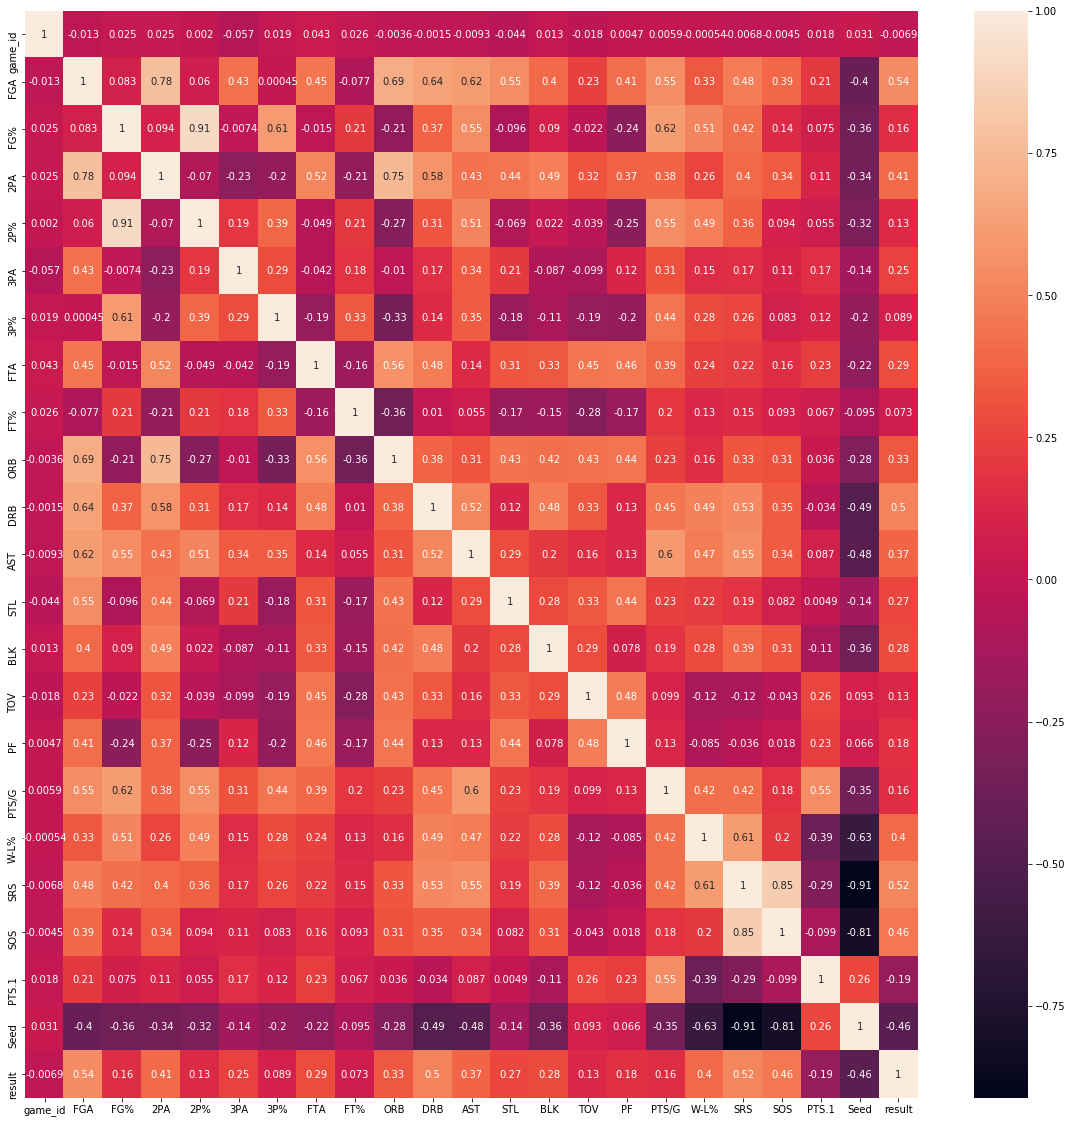

In [60]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(20,20))
corr=data_matrix.corr()
ax=sns.heatmap(corr,annot=True)

Some notable results: <dir>
    * defensive rebounds are more correlated with wins than offensive rebounds
    * almost no correlation between FT% and Wins in NCAA tournament!
    * low correlation between 3P% and 3PA 
        + Perhaps this is something that can be accounted for.
        + Feature engineering could be useful - see what percentage of shots were 3P 

# Nueral Net

This is adapted from the TF example https://www.tensorflow.org/tutorials/keras/classification

In [108]:
import tensorflow as tf
from tensorflow import keras
nueral_net_data = data_matrix.copy()

In [114]:
from sklearn.model_selection import train_test_split
# split the data
Y_nn = nueral_net_data.iloc[: , -1]
X_nn = nueral_net_data.iloc[: , 1:-1]
x_train_nn, x_test_nn, y_train_nn, y_test_nn = train_test_split(X_nn, Y_nn, test_size=0.2)

#### Build the Nueral Net

In [142]:

input_shape = (21,)  # The shape of the data. This cannot be changed.
num_categories = 2 # The number of labelled categories in our classification scheme. This cannot be changed.
hidden_units_list = [16, 64, 256]

# These are our layers
num_hidden_units = hidden_units_list[2] 
num_hidden_units_2 = hidden_units_list[2]
num_hidden_units_3 = hidden_units_list[2]
activation_list = ['sigmoid', 'relu', 'tanh'] # Different options of activation function
activation = activation_list[0]

model = keras.Sequential([
    keras.layers.Flatten(input_shape=input_shape),
    keras.layers.Dense(num_hidden_units, activation=activation),
    keras.layers.Dropout(0.5) ,
    keras.layers.Dense(num_hidden_units_2, activation=activation),
    keras.layers.Dropout(0.25) ,
    keras.layers.Dense(num_hidden_units_3, activation=activation),
    keras.layers.Dropout(0.1) ,
    keras.layers.Dense(num_categories, activation='softmax')
])

print(f"The model is built using {num_hidden_units} hidden units and a {activation} activation function")



The model is built using 256 hidden units and a sigmoid activation function


In [143]:
# adam helps get out of local optima
model.compile(optimizer='adam', # adam is an adaptive gradient optimizer
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.fit(x_train_nn, y_train_nn, epochs=30)

Train on 531 samples
Epoch 1/30
531/531 [==============================] - 0s 618us/sample - loss: 0.6515 - accuracy: 0.6177
Epoch 2/30
531/531 [==============================] - 0s 65us/sample - loss: 0.5737 - accuracy: 0.7269
Epoch 3/30
531/531 [==============================] - 0s 81us/sample - loss: 0.5496 - accuracy: 0.7552
Epoch 4/30
531/531 [==============================] - 0s 71us/sample - loss: 0.5450 - accuracy: 0.7608
Epoch 5/30
531/531 [==============================] - 0s 75us/sample - loss: 0.5324 - accuracy: 0.7759
Epoch 6/30
531/531 [==============================] - 0s 70us/sample - loss: 0.5301 - accuracy: 0.7665
Epoch 7/30
531/531 [==============================] - 0s 88us/sample - loss: 0.5269 - accuracy: 0.7797
Epoch 8/30
531/531 [==============================] - 0s 68us/sample - loss: 0.5168 - accuracy: 0.7853
Epoch 9/30
531/531 [==============================] - 0s 59us/sample - loss: 0.5154 - accuracy: 0.7947
Epoch 10/30
531/531 [==============================

In [145]:
test_loss, test_acc = model.evaluate(x_test_nn,  y_test_nn, verbose=2)

print('\nTest accuracy:', test_acc)

133/133 - 0s - loss: 0.5018 - accuracy: 0.8120

Test accuracy: 0.8120301
